# Decision Tree Demonstration - CIRC DMINE AG



## Loading libraries and importing data.  

This dataset is a ~14000 record dataset of monthly crop loss and acreage values, that has been integrated with GRIDMET daily data - summarized to monthly, and at a county geographic scale - for only Washington.

In [8]:
import pandas as pd
import os
import numpy as np
os.chdir("/agmesh-scenarios/scenario_52177/")
train = pd.read_csv('2001_2015_usda_gridmet_WA_machine', index_col=0)

In [9]:
# create feature matrix (X)
all_cols = ['bi', 'pr', 'pdsi', 'pet', 'erc', 'th', 'vs', 'fm1000', 'fm100', 'srad', 'sph', 'tmmx', 'tmmn', 'rmin', 'rmax', 'loss']
feature_cols = ['bi', 'pr', 'pdsi', 'pet', 'erc', 'th', 'vs', 'fm1000', 'fm100', 'srad', 'sph', 'tmmx', 'tmmn', 'rmin', 'rmax']

X = train[feature_cols]

# create response vector (y)
y = train.loss

train = train[all_cols]

## Set up training and testing 

In [10]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
train.loss

year
2001     110761.00
2001      83266.00
2001       2203.20
2001        397.20
2001        261.00
2001      34222.05
2001       3324.00
2001        417.00
2001       1098.00
2001       8619.00
2001      27951.40
2001     101623.00
2001      48331.00
2001     149509.00
2001      87306.00
2001     109267.00
2001       4902.00
2001     373007.00
2001       4185.00
2001      28045.00
2001     130909.00
2001     528212.00
2001      27670.00
2001       2952.38
2001       5816.00
2001       1574.37
2001       8515.10
2001      24282.00
2001      27765.00
2001       7770.00
           ...    
2015      20668.80
2015     200431.00
2015       5101.60
2015       4953.00
2015      19535.00
2015        811.00
2015        398.34
2015     135329.32
2015       1666.00
2015       4822.40
2015       2155.80
2015       3727.76
2015        813.00
2015     447848.39
2015       7621.66
2015       3249.00
2015     119683.00
2015    2572130.24
2015        892.50
2015       2150.00
2015       2872.00
2015   

## Building a regression tree in scikit-learn

In [12]:
# instantiate a DecisionTreeRegressor (with random_state=1)
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=1, splitter='best')

In [13]:
# use 10 fold CV to estimate the RMSE for this model
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(treereg, X, y, cv=10, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

423607.46564580017

## Tuning regression tree

Let's try to reduce the RMSE by tuning the **max_depth** parameter:

In [14]:
# try different values one-by-one
treereg = DecisionTreeRegressor(max_depth=1, random_state=1)
scores = cross_val_score(treereg, X, y, cv=10, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

341391.80108382751

## Looping thru a set number of max_depths to see the optimum level

In [15]:
# list of values to try
max_depth_range = range(1, 50)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use LOOCV with each value of max_depth
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=14, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [17]:
matplotlib 
import matplotlib.pyplot as plt
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

TclError: no display name and no $DISPLAY environment variable

In [28]:
# max_depth=3 was best, so fit a tree using that parameter
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=1, splitter='best')

In [29]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

feature  importance
0       bi    0.000000
1       pr    0.000000
2     pdsi    0.000000
3      pet    0.000000
4      erc    0.000000
5       th    0.443436
6       vs    0.124707
7   fm1000    0.000000
8    fm100    0.382797
9     srad    0.013721
10     sph    0.035339
11    tmmx    0.000000
12    tmmn    0.000000
13    rmin    0.000000
14    rmax    0.000000

## Creating a tree diagram

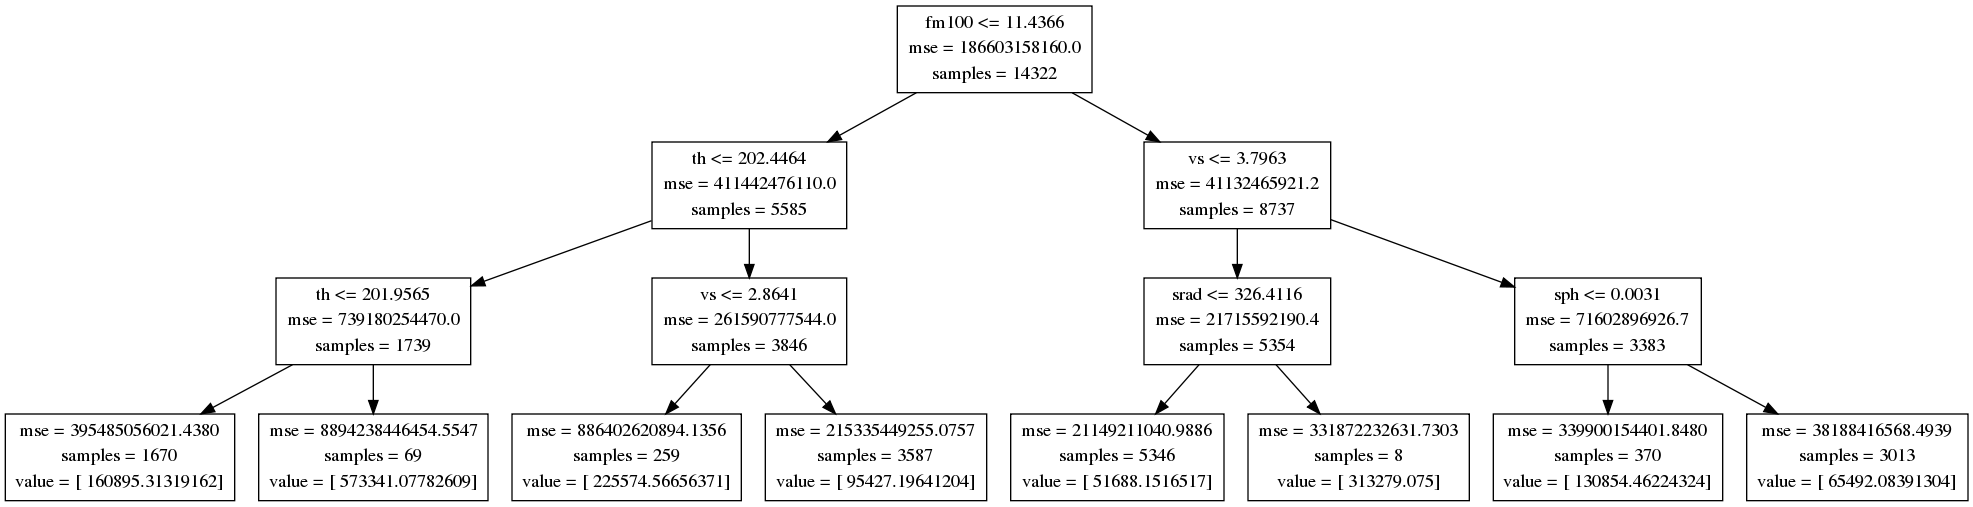

In [33]:
# create a Graphviz file
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='tree_ag.dot', feature_names=feature_cols)

from IPython.display import Image
Image(filename='tree_ag.png')
# At the command line, run this to convert to PNG:
# dot -Tpng tree_vehicles.dot -o tree_vehicles.png

## Making predictions for the testing data

In [20]:
# read the testing data
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/vehicles_test.csv'
test = pd.read_csv(url)
test['vtype'] = test.vtype.map({'car':0, 'truck':1})
test

price  year   miles  doors  vtype
0   3000  2003  130000      4      1
1   6000  2005   82500      4      0
2  12000  2010   60000      2      0

**Question:** Using the tree diagram above, what predictions will the model make for each observation?

In [21]:
# use fitted model to make predictions on testing data
X_test = test[feature_cols]
y_test = test.price
y_pred = treereg.predict(X_test)
y_pred

array([  4000.,   5000.,  13500.])

In [22]:
# calculate RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

1190.2380714238084

In [23]:
# calculate RMSE for your own tree!
y_test = [3000, 6000, 12000]
y_pred = [0, 0, 0]
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

7937.2539331937714

## Comparing regression trees and classification trees

|regression trees|classification trees|
|---|---|
|predict a continuous response|predict a categorical response|
|predict using mean response of each leaf|predict using most commonly occuring class of each leaf|
|splits are chosen to minimize MSE|splits are chosen to minimize Gini index (discussed below)|

## Splitting criteria for classification trees

Common options for the splitting criteria:

- **classification error rate:** fraction of training observations in a region that don't belong to the most common class
- **Gini index:** measure of total variance across classes in a region

### Example of classification error rate

Pretend we are predicting whether someone buys an iPhone or an Android:

- At a particular node, there are **25 observations** (phone buyers), of whom **10 bought iPhones and 15 bought Androids**.
- Since the majority class is **Android**, that's our prediction for all 25 observations, and thus the classification error rate is **10/25 = 40%**.

Our goal in making splits is to **reduce the classification error rate**. Let's try splitting on gender:

- **Males:** 2 iPhones and 12 Androids, thus the predicted class is Android
- **Females:** 8 iPhones and 3 Androids, thus the predicted class is iPhone
- Classification error rate after this split would be **5/25 = 20%**

Compare that with a split on age:

- **30 or younger:** 4 iPhones and 8 Androids, thus the predicted class is Android
- **31 or older:** 6 iPhones and 7 Androids, thus the predicted class is Android
- Classification error rate after this split would be **10/25 = 40%**

The decision tree algorithm will try **every possible split across all features**, and choose the split that **reduces the error rate the most.**

### Example of Gini index

Calculate the Gini index before making a split:

$$1 - \left(\frac {iPhone} {Total}\right)^2 - \left(\frac {Android} {Total}\right)^2 = 1 - \left(\frac {10} {25}\right)^2 - \left(\frac {15} {25}\right)^2 = 0.48$$

- The **maximum value** of the Gini index is 0.5, and occurs when the classes are perfectly balanced in a node.
- The **minimum value** of the Gini index is 0, and occurs when there is only one class represented in a node.
- A node with a lower Gini index is said to be more "pure".

Evaluating the split on **gender** using Gini index:

$$\text{Males: } 1 - \left(\frac {2} {14}\right)^2 - \left(\frac {12} {14}\right)^2 = 0.24$$
$$\text{Females: } 1 - \left(\frac {8} {11}\right)^2 - \left(\frac {3} {11}\right)^2 = 0.40$$
$$\text{Weighted Average: } 0.24 \left(\frac {14} {25}\right) + 0.40 \left(\frac {11} {25}\right) = 0.31$$

Evaluating the split on **age** using Gini index:

$$\text{30 or younger: } 1 - \left(\frac {4} {12}\right)^2 - \left(\frac {8} {12}\right)^2 = 0.44$$
$$\text{31 or older: } 1 - \left(\frac {6} {13}\right)^2 - \left(\frac {7} {13}\right)^2 = 0.50$$
$$\text{Weighted Average: } 0.44 \left(\frac {12} {25}\right) + 0.50 \left(\frac {13} {25}\right) = 0.47$$

Again, the decision tree algorithm will try **every possible split**, and will choose the split that **reduces the Gini index (and thus increases the "node purity") the most.**

### Comparing classification error rate and Gini index

- Gini index is generally preferred because it will make splits that **increase node purity**, even if that split does not change the classification error rate.
- Node purity is important because we're interested in the **class proportions** in each region, since that's how we calculate the **predicted probability** of each class.
- scikit-learn's default splitting criteria for classification trees is Gini index.

Note: There is another common splitting criteria called **cross-entropy**. It's numerically similar to Gini index, but slower to compute, thus it's not as popular as Gini index.

## Building a classification tree in scikit-learn

We'll build a classification tree using the Titanic data:

In [24]:
# read in the data
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/titanic.csv'
titanic = pd.read_csv(url)

# encode female as 0 and male as 1
titanic['Sex'] = titanic.Sex.map({'female':0, 'male':1})

# fill in the missing values for age with the median age
titanic.Age.fillna(titanic.Age.median(), inplace=True)

# create a DataFrame of dummy variables for Embarked
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)

# concatenate the original DataFrame and the dummy DataFrame
titanic = pd.concat([titanic, embarked_dummies], axis=1)

# print the updated DataFrame
titanic.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex  Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1   22      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0   38      1      0   
2                             Heikkinen, Miss. Laina    0   26      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0   35      1      0   
4                           Allen, Mr. William Henry    1   35      0      0   

             Ticket     Fare Cabin Embarked  Embarked_Q  Embarked_S  
0         A/5 21171   7.2500   NaN        S           0           1  
1          PC 17599  71.2833   C85        C           0           0  
2  STON/O2. 3101282   7.9250   NaN        S           0           1  
3            113803  53.1000  C123        S           0           1  
4            373450   8.0500   NaN        S           0           1

- **Survived:** 0=died, 1=survived (response variable)
- **Pclass:** 1=first class, 2=second class, 3=third class
    - What will happen if the tree splits on this feature?
- **Sex:** 0=female, 1=male
- **Age:** numeric value
- **Embarked:** C or Q or S

In [25]:
# define X and y
feature_cols = ['Pclass', 'Sex', 'Age', 'Embarked_Q', 'Embarked_S']
X = titanic[feature_cols]
y = titanic.Survived

In [26]:
# fit a classification tree with max_depth=3 on all data
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=1, splitter='best')

In [27]:
# create a Graphviz file
export_graphviz(treeclf, out_file='tree_titanic.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_titanic.dot -o tree_titanic.png

![Tree for Titanic data](images/tree_titanic.png)

Notice the split in the bottom right: the **same class** is predicted in both of its leaves. That split didn't affect the **classification error rate**, though it did increase the **node purity**, which is important because it increases the accuracy of our predicted probabilities.

In [28]:
# compute the feature importances
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

feature  importance
0      Pclass    0.242664
1         Sex    0.655584
2         Age    0.064494
3  Embarked_Q    0.000000
4  Embarked_S    0.037258

# Part 3: Comparing decision trees with other models

**Advantages of decision trees:**

- Can be used for regression or classification
- Can be displayed graphically
- Highly interpretable
- Can be specified as a series of rules, and more closely approximate human decision-making than other models
- Prediction is fast
- Features don't need scaling
- Automatically learns feature interactions
- Tends to ignore irrelevant features
- Non-parametric (will outperform linear models if relationship between features and response is highly non-linear)

![Trees versus linear models](images/tree_vs_linear.png)

**Disadvantages of decision trees:**

- Performance is (generally) not competitive with the best supervised learning methods
- Can easily overfit the training data (tuning is required)
- Small variations in the data can result in a completely different tree (high variance)
- Recursive binary splitting makes "locally optimal" decisions that may not result in a globally optimal tree
- Doesn't tend to work well if the classes are highly unbalanced
- Doesn't tend to work well with very small datasets